<b><font size="10"><center>Heart Failure Prediction</center></font></b>

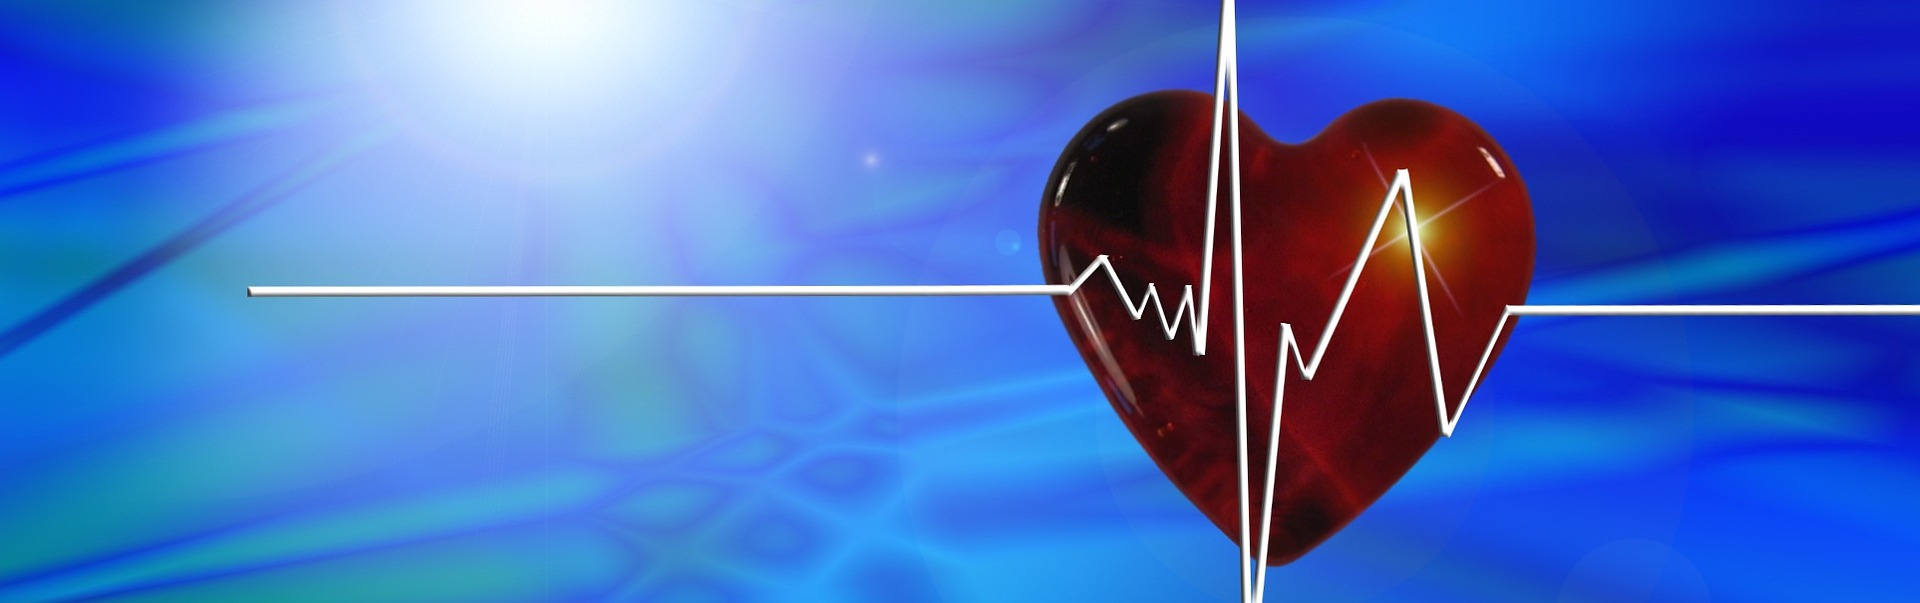

***

<font size="4">This database has been sourced from kaggle (link: https://www.kaggle.com/andrewmvd/heart-failure-clinical-data). The goal is to see whether we can predict heart failure from the features available to us. Since this effort requires a binary categorical prediction, we will use two commonly applied classification algorithms - Logistic Regression and Random Forests. We will also explore if we can improve performance by feature engineering, and compare performance across.</font>


### References

1. Ahmad, Tanvir; Munir, Assia; Bhatti, Sajjad Haider; Aftab, Muhammad; Ali Raza, Muhammad (2017): DATA_MINIMAL.. PLOS ONE. Dataset. https://doi.org/10.1371/journal.pone.0181001.s001 


2. Chicco, D., Jurman, G. Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Med Inform Decis Mak 20, 16 (2020). https://doi.org/10.1186/s12911-020-1023-5

***

# Setting up

<font size="3">Data Processing and Visualization Modules</font>

1. Numpy
2. Pandas
3. Seaborn
4. Matplotlib

<font size="3">Machine Learning Modules</font>

1. Model Selection
2. Logistic Regression
3. Random Forest Classifier
4. Robust Scaler
5. Confusion Matrix
6. Classification Report

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, classification_report

<font size="3">Importing data</font>

In [ ]:
hfp = pd.read_csv('../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')

<font size="3">Structure of our data</font>

In [ ]:
hfp.head()

In [ ]:
hfp.describe()

In [ ]:
hfp.info()

***

# Data Visualizations

<b><font size="4">1. Correlation Matrix</font></b>

In [ ]:
fig = plt.figure(figsize=[16, 9])
plt.style.use('seaborn-darkgrid')
sns.heatmap(hfp.corr(), annot=True, mask=np.triu(hfp.corr()), cmap='coolwarm')

<font size="3">The above heatmap gives us a sense of what variables could possibly help us predicting the incidence of a cardiac arrest. We can see what these variables mean.</font>

<font size="3">Observations:</font>

1. Age of patient - The risk of developing heart disease increases with age, as pointed out in the following article - https://www.nia.nih.gov/health/heart-health-and-aging#:~:text=Adults%20age%2065%20and%20older,risk%20of%20developing%20cardiovascular%20disease


2. Percentage of blood leaving the heart at each contraction - Heart failure with reduced ejection fraction happens when the muscle of the left ventricle is not pumping as well as normal (ejection fraction is 40% or less), and hence the negative correlation makes sense - https://www.uofmhealth.org/health-library/tx4090abc#:~:text=A%20normal%20ejection%20fraction%20is,fraction%20is%2040%25%20or%20less


3. Level of serum creatinine in the blood (mg/dL) - High serum creatinine levels are associated with heart failure - https://www.onlinejcf.com/article/S1071-9164(02)25410-X/fulltext#:~:text=A%20prior%20study%20from%20this,of%20stay%20and%20mortality%20risk


4. Level of serum sodium in the blood (mEq/L) - Hyponatremia (serum sodium concentration of <135 mEq/L) is one of the crucial factors in the clinical prognosis of heart failure patients - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6224129/


5. Follow-up period (days) - This is an interesting feature, since it has a high correlation with DEATH_EVENT. However, upon closer inspection this feature essentially reports the days after taking measurements the patient died (1) or lost contact (0). In a scenario where we want to predict a patient outcome, we will not have this variable, and hence it makes sense to drop this variable altogether.

In [ ]:
hfp.drop('time', axis=1, inplace=True)
hfp.head()

In [ ]:
%matplotlib inline

_ = [1, 3, 5, 9, 10]
_ = list(enumerate([list(hfp.columns)[i] for i in _], start=1))

fig = plt.figure(figsize=[18,12])
for index, col_name in _:
    ax = fig.add_subplot(2, 3, index)
    sns.countplot(x=col_name, data=hfp, hue="DEATH_EVENT", palette='magma')

ax = fig.add_subplot(2, 3, 6)
sns.countplot(x='DEATH_EVENT', data=hfp, palette='magma')

<font size="3">Observations:</font>

1. This is an unbalanced classification problem i.e. there are fewer cases of deaths due to heart failure as compared to survival (~31% of total)


2. Only high_blood_pressure variable seems to have a noticeable effect on the DEATH_EVENT variable


3. Other variables do not seem to impart much information. However, we will still keep these variables as we don't have an issue of dimensionality, and the variables are not highly correlated to each other as we observed in the correlation matrix above. Another consideration is that the classification accuracy may reduce if we drop these variables.

In [ ]:
%matplotlib inline

_ = [0, 2, 4, 6, 7, 8]
_ = list(enumerate([list(hfp.columns)[i] for i in _], start=1))
_

fig = plt.figure(figsize=[18,12])
for index, col_name in _:
    ax = fig.add_subplot(2, 3, index)
    sns.distplot(hfp[col_name])

In [ ]:
%matplotlib inline

_ = [0, 2, 4, 6, 7, 8]
_ = list(enumerate([list(hfp.columns)[i] for i in _], start=1))
_

fig = plt.figure(figsize=[18,12])
for index, col_name in _:
    ax = fig.add_subplot(2, 3, index)
    sns.boxplot(x=col_name, y='DEATH_EVENT', data=hfp, palette="coolwarm", orient='h')

<font size="3">Observations:</font>

1. In both the above set of visualizations, we can see that serum_creatinine and creatinine_phosphokinase variables have a lot of outliers. We will see if we can deal with these by scaling. A min max scaler will not work since it is affected by extreme values, and will not do much as far as reducing variance is concerned.


2. Another data transformation to explore would be convert serum_creatinine and creatinine_phosphokinase into a binary categorical variables, basis certain cutoff point. A category value of 1 would indicate elevated creatinine levels or Hyponatremia respectively.

***

# Data Pre-Processing

<b><font size="4">Methodology</font></b>

We will create 3 separate datasets with different levels of feature engineering


- Data set 1: No transformations
- Data set 2: Converting serum_sodium and serum_creatinine to binary variables
- Data set 3: Applying RobustScaler

Making three copies of the data set

In [ ]:
hfp_dfs = [hfp.copy() for i in range(3)]

Transformation 1: Transformation of variables

The following studies were helpful in getting intuition as to how we can better use some of the features in our dataset

1. Serum creatinine - According to a study (https://www.ahajournals.org/doi/full/10.1161/01.str.28.3.557) published in 1997 done on middle-aged men, elevated serum creatinine level is linked to a higher risk of CVD. Higher risk of CVD was observed where serum creatinine levels are higher than 130 µmol/L, or 1.47 mg/dL*

    <font size="1">*Conversion units taken as 1 mg/dL = 0.0113 µmol/L - http://www.endmemo.com/medical/unitconvert/Creatinine.php</font>


2. Serum Sodium - A 2018 (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6224129/) study links heart failure to Hyponatremia (serum sodium concentration of less than 135 mEq/L)

In [ ]:
# Classifying as Hyponatremia (1) for Serum Sodium levels of less than 135 mEq/L or normal (0)
hfp_dfs[1]['serum_sodium'] = hfp_dfs[1]['serum_sodium'].apply(lambda x: 1 if x < 135 else 0)

# Classifying as elevated Serum Creatinine (1) for levels of more than 1.47 mg/dl or normal (0)
hfp_dfs[1]['serum_creatinine'] = hfp_dfs[1]['serum_creatinine'].apply(lambda x: 1 if x >= 1.47 else 0)

Splitting into testing and training data sets

In [ ]:
# Creating three data sets, which will be stored as a dictionary 
# of the format {'X_train': df, 'X_test': df, 'y_train': Series, 'y_test': Series}

key_names = ['X_train', 'X_test', 'y_train', 'y_test']

for i in range(3):
    X = hfp_dfs[i].drop('DEATH_EVENT', axis=1)
    y = hfp_dfs[i]['DEATH_EVENT']
    
    _ = train_test_split(X,y,test_size=0.2,random_state=100)
    _ = dict(zip(key_names, _))
    
    hfp_dfs[i] = _

Tranformation 2: Applying RobustScaler

In [ ]:
scaler = RobustScaler()
scaler.fit(hfp_dfs[2]['X_train'])

hfp_dfs[2]['X_train'] = scaler.transform(hfp_dfs[2]['X_train'])
hfp_dfs[2]['X_test'] = scaler.transform(hfp_dfs[2]['X_test'])

In [ ]:
hfp_dfs[2]['X_train'] = pd.DataFrame(hfp_dfs[2]['X_train'], columns=['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 
                                                                     'ejection_fraction', 'high_blood_pressure', 'platelets', 
                                                                     'serum_creatinine', 'serum_sodium', 'sex', 'smoking'])

hfp_dfs[2]['X_test'] = pd.DataFrame(hfp_dfs[2]['X_test'], columns=['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 
                                                                     'ejection_fraction', 'high_blood_pressure', 'platelets', 
                                                                     'serum_creatinine', 'serum_sodium', 'sex', 'smoking'])

***

# Modeling

<b><font size="4">Methodology</font></b>

We will run Logistic Regression and Random Forest classification algorithms on all of our datasets, comparing performance across different levels of feature engineering and exploring further parameters we can modify to improve our prediction

<b><font size="4">Logistic Regression</font></b>

Creating Logistic Regression Models on our datasets

In [ ]:
model_list = []

for i in range(3):
    
    log_model = LogisticRegression(max_iter=100000)
    log_model.fit(hfp_dfs[i]['X_train'], hfp_dfs[i]['y_train'])
    
    predictions = log_model.predict(hfp_dfs[i]['X_test'])
    
    print(classification_report(hfp_dfs[i]['y_test'], predictions))
    print(confusion_matrix(hfp_dfs[i]['y_test'], predictions))
    
    model_list.append(log_model)

<b><font size="4">Random Forest</font></b>

Creating Random Forest models on our datasets

In [ ]:
rf_list = []

for i in range(3):     
    rfc = RandomForestClassifier(n_estimators=100)
    rfc.fit(hfp_dfs[i]['X_train'], hfp_dfs[i]['y_train'])

    rfc_pred = rfc.predict(hfp_dfs[i]['X_test'])

    print(classification_report(hfp_dfs[i]['y_test'], rfc_pred))
    print(confusion_matrix(hfp_dfs[i]['y_test'], rfc_pred))
    
    rf_list.append(rfc)

<b><font size="4">Logistic Regression with class weights</font></b>

In [ ]:
class_w = {0:1, 1:3}

model_list_1 = []

for i in range(3):
    
    log_model = LogisticRegression(max_iter=100000, class_weight=class_w)
    log_model.fit(hfp_dfs[i]['X_train'], hfp_dfs[i]['y_train'])
    
    predictions = log_model.predict(hfp_dfs[i]['X_test'])
    
    print(classification_report(hfp_dfs[i]['y_test'], predictions))
    print(confusion_matrix(hfp_dfs[i]['y_test'], predictions))
    
    model_list_1.append(log_model)

<b><font size="4">Random forests with class weights</font></b>

In [ ]:
rf_list_1 = []

for i in range(3):     
    rfc = RandomForestClassifier(n_estimators=100, class_weight=class_w)
    rfc.fit(hfp_dfs[i]['X_train'], hfp_dfs[i]['y_train'])

    rfc_pred = rfc.predict(hfp_dfs[i]['X_test'])

    print(classification_report(hfp_dfs[i]['y_test'], rfc_pred))
    print(confusion_matrix(hfp_dfs[i]['y_test'], rfc_pred))
    
    rf_list_1.append(rfc)

<font size="3">Observations:</font>

1. We see that Logistic Regression performs best on dataset with transformed variables. However, even though we have an overall accuracy of 70%, our recall on the predicted class (1) is 48%. Hence, we are only classifying the incidence of heart failure half the time, which is not good performance. This could be due to unbalanced classes, and not enough instances of heart failure for the model to learn from.


2. We get considerable improvement from Random Forest over Logistic Regression, both in terms of accuracy and recall. This could be due to Random Forests being inherently better with unbalanced classes due to drawing samples repeatedly.


3. Applying class weights to the cost function did not really improve upon the results much in terms of accuracy. However, we achieved around 80% recall on the predicted class (1), which could be worth the trade-off on accuracy since we would want to error on the side of caution.

# Conclusion

In a real world use case, we would ideally want to go with the Logistic Regression model, as even though the overall accuracy may be less, the high recall on predicted class means that there will be fewer misclassifications of patients who are actually at a risk of heart failure. This will have a positive effect on patient care outcomes.  

<b><font size='4'>Next Steps</font></b>

1. Get more data points


2. Hyperparameter tuning


3. Oversampling the imbalanced class with techniques (for e.g. SMOTE)